# Subsetting STOFS-3D-Atl field2d.nc Files 
We are subsetting abd visualizing the forecast data from STOFS-3D-Atl data.

To begin, load the environment. `source /nhc/Atieh.Alipour/environment/miniconda3/bin/activate  env_subsetting` 

## Modifying Node Connectivity and Dimension Names in filed2d.nc Files 

The filed2d.nc files exhibit different node connectivity, possibly due to some masking of the original node connectivity files. To facilitate data subsetting using the Thalassa package, we need to make adjustments to the node connectivities and certain dimension names.

In [1]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp



In [2]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)  # Enable anonymous access to the S3 bucket
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])  # Open NetCDF dataset and drop 'nvel' variable
    return ds

In [3]:
def normalize_data(ds, bucket_name, base_key, filename, date):
    """
    Function to modify/normalize a dataset using the Thalassa package.

    Parameters:
    - ds: xarray Dataset containing the data
    - bucket_name: Name of the S3 bucket
    - base_key: Base key for the dataset in the S3 bucket
    - filename: Original filename to be replaced
    - date: Date string for the new filename

    Returns:
    - normalized_ds: Thalassa dataset ready for cropping or visualizing
    """

    if 'element' in ds:
        normalized_ds = thalassa.normalize(ds)
    else:
        key = f'{base_key}/{filename}'
        ds_with_element_key = key.replace(filename, f'schout_adcirc_{date}.nc')
        ds_with_element = read_netcdf_from_s3(bucket_name, ds_with_element_key)  # Read NetCDF data from S3 bucket

        # Modify the field2d.nc file based on schout_adcirc.nc file
        ds = ds.rename({'nSCHISM_hgrid_node': 'node', 'nSCHISM_hgrid_face': 'nele', 'nMaxSCHISM_hgrid_face_nodes': 'nvertex'})
        ds = ds.drop_dims('nele')  # Drop nele variable if it exists
        ds['nele'] = ds_with_element['nele']
        ds['nvertex'] = ds_with_element['nvertex']
        ds['element'] = ds_with_element['element']
        ds = ds.rename({'SCHISM_hgrid_node_x': 'x', 'SCHISM_hgrid_node_y': 'y'})

        # Normalize data
        normalized_ds = thalassa.normalize(ds)

    return normalized_ds

In [4]:
def subset_thalassa(ds, box):
    """
    Function to subset a thalassa Dataset based on a bounding box using shapely.
    
    Parameters:
    - ds: thalassa Dataset containing the data
    - box: Tuple representing the bounding box (x_min, x_max, y_min, y_max)
    
    Returns:
    - new_ds: Subset of the input dataset within the specified bounding box
    """
    bbox = shapely.box(box[0], box[2], box[1], box[3])  # Create a shapely box from the bounding box coordinates
    new_ds = thalassa.crop(ds, bbox)  # Crop the dataset using the bounding box
    return new_ds


In [5]:

def save_subset_to_netcdf(xarray_ds, output_file):
    """
    Function to save a subset of an xarray Dataset to a NetCDF file.
    
    Parameters:
    - xarray_ds: Subset of the xarray Dataset
    - output_file: Path to save the output NetCDF file
    """
    xarray_ds.to_netcdf(output_file)  # Save the subset to a NetCDF file



# 1- Read and Subet data on the Fly

The following lines of code read data, normalize it, and subset the data. 

Skip saving the data if you don't need to save the subset data and just want to visualize.

Change the date and filename to explore different dates

In [6]:
# Reading data

start_time = time.time()  # Record the start time

bucket_name = 'noaa-nos-stofs3d-pds'
#key = 'STOFS-3D-Atl/stofs_3d_atl.20240325/schout_adcirc_20240325.nc'
date= '20240325'
base_key = f'STOFS-3D-Atl/stofs_3d_atl.{date}'
#Possible filenames: filenames = ['stofs_3d_atl.t12z.f001_024.field2d.nc', 'stofs_3d_atl.t12z.f025_048.field2d.nc', 'stofs_3d_atl.t12z.n001_024.field2d.nc']
filename = 'stofs_3d_atl.t12z.f001_024.field2d.nc'
key = f'{base_key}/{filename}'
dataset = read_netcdf_from_s3(bucket_name, key)  # Read NetCDF data from S3 bucket

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time for reading data: {execution_time} seconds")  # Print execution time


Execution time for reading data: 9.974045276641846 seconds


In [7]:
#Prepare data for subsetting and visualization

start_time = time.time()  # Record the start time

normalize_dataset = normalize_data(dataset, bucket_name, base_key, filename, date)
end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time for normalizing: {execution_time} seconds")  # Print execution time


Execution time for normalizing: 8.274687767028809 seconds


In [8]:
# Subset Data

start_time = time.time()  # Record the start time

# Define the bounding box
box = (-76.6, -76.4, 39.1, 39.3)

ds2 = subset_thalassa(normalize_dataset, box)  # Subset the thalassa dataset

end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate execution time
print(f"Execution time for subsetting: {execution_time} seconds")  # Print execution time


Execution time for subsetting: 2.465284585952759 seconds


In [9]:
# Skip this part
#Change to True if you want to save subset data

if False:
    start_time = time.time()  # Record the start time
    output_file = 'stofs3D_subset_test.nc'
    save_subset_to_netcdf(ds2, output_file)  # Save the subset to a NetCDF file
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time  # Calculate execution time
    print(f"Execution time for writing: {execution_time} seconds")  # Print execution time


# 2- Estimate Current Magnitude and Direction

One of the variables that we are interested in is current. We want to visualize both current magnitude and direction. 

Here, we first estimate these values for the subset data and save them in the same dataset.

In [10]:
ds2

<xarray.Dataset> Size: 107MB
Dimensions:          (time: 24, node: 1024, face: 5235307, max_no_vertices: 3,
                      triface: 1779, three: 3)
Coordinates:
  * time             (time) datetime64[ns] 192B 2024-03-25T13:00:00 ... 2024-...
  * face             (face) int64 42MB 0 1 2 3 ... 5235304 5235305 5235306
  * max_no_vertices  (max_no_vertices) int64 24B 0 1 2
Dimensions without coordinates: node, triface, three
Data variables: (12/16)
    lon              (node) float64 8kB -76.54 -76.54 -76.54 ... -76.4 -76.4
    lat              (node) float64 8kB 39.11 39.11 39.11 ... 39.29 39.29 39.3
    depth            (node) float32 4kB ...
    elev             (time, node) float64 197kB ...
    temp_surface     (time, node) float64 197kB ...
    temp_bottom      (time, node) float64 197kB ...
    ...               ...
    uvel_bottom      (time, node) float64 197kB ...
    vvel_bottom      (time, node) float64 197kB ...
    uvel4.5          (time, node) float64 197kB ...
    vvel4.5          (time, node) float64 197kB ...
    face_nodes       (face, max_no_vertices) int32 63MB 1 7 ... 2654148 2654151
    triface_nodes    (triface, three) int32 21kB 0 1 2 3 ... 1023 1021 1022 1019
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/

In [11]:
# Calculate magnitude using Pythagorean theorem
ds2['uv_mag_surface'] = np.sqrt(ds2['uvel_surface']**2 + ds2['vvel_surface']**2)

# Calculate angle in radians using arctangent (atan2)
# calculates the angle relative to the positive y-axis 
angle_rad = np.pi / 2 - np.arctan2(-ds2['vvel_surface'], -ds2['uvel_surface'])

# Convert angle from radians to degrees
ds2['uv_angle_deg'] = np.degrees(angle_rad)
#ds2['uv_angle_deg'] = angle_rad

In [12]:
ds2

<xarray.Dataset> Size: 107MB
Dimensions:          (time: 24, node: 1024, face: 5235307, max_no_vertices: 3,
                      triface: 1779, three: 3)
Coordinates:
  * time             (time) datetime64[ns] 192B 2024-03-25T13:00:00 ... 2024-...
  * face             (face) int64 42MB 0 1 2 3 ... 5235304 5235305 5235306
  * max_no_vertices  (max_no_vertices) int64 24B 0 1 2
Dimensions without coordinates: node, triface, three
Data variables: (12/18)
    lon              (node) float64 8kB -76.54 -76.54 -76.54 ... -76.4 -76.4
    lat              (node) float64 8kB 39.11 39.11 39.11 ... 39.29 39.29 39.3
    depth            (node) float32 4kB ...
    elev             (time, node) float64 197kB ...
    temp_surface     (time, node) float64 197kB ...
    temp_bottom      (time, node) float64 197kB ...
    ...               ...
    uvel4.5          (time, node) float64 197kB ...
    vvel4.5          (time, node) float64 197kB ...
    face_nodes       (face, max_no_vertices) int32 63MB 1 7 ... 2654148 2654151
    triface_nodes    (triface, three) int32 21kB 0 1 2 3 ... 1023 1021 1022 1019
    uv_mag_surface   (time, node) float64 197kB 0.0 0.0 0.0 0.0 ... nan nan nan
    uv_angle_deg     (time, node) float64 197kB 270.0 270.0 270.0 ... nan nan
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/

# 3- Plotting

Plotting different variables of interest.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
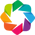

In [15]:

#ds2 = xr.open_dataset('./20240328/stofs_3d_atl.t12z.f025_048.field2d.nc') If you are reading data from your local machine
hv.extension("bokeh")



In [16]:
#vectorfield = gv.VectorField((ds['lon'], ds['lon'], 1000 * ds['uv_ang_surface'][1,:], ds['uv_mag_surface'][1,:]))


variable, layer, timestamp = "uv_mag_surface", None, ds2.time.values[4]


# The trimesh is the most basic object. This is what you need to create all the others graphs
# It is on this object that you specify the timestamp and/or the layer.
trimesh = api.create_trimesh(ds2.sel(time=timestamp), variable=variable)

# The wireframe is the representation of the mesh
wireframe = api.get_wireframe(trimesh)

# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

# The raster object is the basic Map that visualizes the variable. 
# You can specify things like the colorbar limits and/or the extents
#raster = api.get_raster(trimesh, clim_min=0, clim_max=15)
raster = api.get_raster(trimesh)

# The pointer/tap timeseries extract the timeseries of a specific node from the xr.Dataset and visualize it.
pointer_dmap = api.get_pointer_timeseries(ds=ds2, variable=variable, source_raster=raster)

# Create and customize the magnitude timeseries plot
tap_dmap_uv_mag = api.get_tap_timeseries(ds=ds2, variable=variable, source_raster=raster)
tap_dmap_uv_mag.opts(
    width=250, height=250, title="Magnitude",
    xlabel="Time",  # Use default if units not present
    ylabel="velocity (m/s)"
)

# Create and customize the angle timeseries plot
tap_dmap_uv_ang = api.get_tap_timeseries(ds=ds2, variable='uv_angle_deg', source_raster=raster)
tap_dmap_uv_ang.opts(
    width=250, height=250, title="Angle",
    xlabel="Time",  # Use default if units not present
    ylabel="Angle (degrees)"
)

lat_br_mid =  39.217192
lon_br_mid = -76.528318
Key_bridge = ( lon_br_mid,lat_br_mid , 'KeyBrj')
kb = gv.Points([Key_bridge], vdims='Brj.').opts(color="red", marker="circle_dot", size=4)

raster_layout = tiles * raster.opts(width=400, height = 400, cmap="viridis", title="Surface Magnitude")
lay = raster_layout * wireframe  * kb + tap_dmap_uv_mag.opts() + tap_dmap_uv_ang.opts()
lay

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .WMTS.I   :WMTS   [Longitude,Latitude]
         .Image.I  :Image   [lon,lat]   (lon_lat uv_mag_surface)
         .Image.II :Image   [lon,lat]   (lon_lat Count)
         .Points.I :Points   [Longitude,Latitude]   (Brj.)
   .DynamicMap.II  :DynamicMap   []
      :Curve   [x]   (y)
   .DynamicMap.III :DynamicMap   []
      :Curve   [x]   (y)

In [17]:
raster_layout = tiles * raster.opts(width=400, height = 400, cmap="viridis", title="Surface Currents")
lay = raster_layout * wireframe  * kb + tap_dmap_uv_mag.opts() + tap_dmap_uv_ang.opts()
lay

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .WMTS.I   :WMTS   [Longitude,Latitude]
         .Image.I  :Image   [lon,lat]   (lon_lat uv_mag_surface)
         .Image.II :Image   [lon,lat]   (lon_lat Count)
         .Points.I :Points   [Longitude,Latitude]   (Brj.)
   .DynamicMap.II  :DynamicMap   []
      :Curve   [time]   (uv_mag_surface)
   .DynamicMap.III :DynamicMap   []
      :Curve   [time]   (uv_angle_deg)

In [20]:
# Convert the interactive plot to a Bokeh figure
bokeh_figure = hv.render(lay, backend='bokeh')

# Specify the output file
bp.output_file("FrancisScottKeyBridge_Current.html")

# Save the Bokeh figure
bp.save(bokeh_figure)


You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/js_callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



'/nhc/Atieh.Alipour/code/subsetting/Subsetting/Tests/FrancisScottKeyBridge_Current.html'